This is a quick example showing how to use the code with the ISBI 2012 data set.

Note that the sample weights provided here are *not* the best possible - for best results one would want to train for longer.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys, time
from socket import gethostname

import numpy as np
import pylab as plt

np.random.seed(9999)

import keras
from keras import backend as K
from keras.models import load_model

sys.path.append('../..')
from cnn_tools import *
from data_tools import *


K.set_image_dim_ordering('th')

print('Using Keras version: %s' % keras.__version__)

Using Theano backend.


Using Keras version: 2.0.2


In [2]:
# load test data
isbi_dir = os.path.expanduser('~/Data/ISBI-2012')
X_test = load_multilayer_tiff(os.path.join(isbi_dir, 'test-volume.tif'))
X_test = X_test / 255.
    
print('[info]: test data has shape:     ', X_test.shape)

# load model
model = create_unet((1, 256, 256))
model.load_weights('./weights_epoch0011.hdf5')

print('[info]: model input shape: ', model.input_shape)

[info]: test data has shape:      (30, 1, 512, 512)
[info]: model input shape:  (None, 1, 256, 256)


In [3]:
# deploy
tic = time.time()
Y_hat = deploy_model(X_test, model)
print('[info]: total time to deploy on system "%s": %0.2f sec' % (gethostname(), (time.time() - tic)))
print('[info]: Y_hat shape: ', Y_hat.shape)

[info]: total time to deploy on system "pekalmj1-ml2": 90.51 sec
[info]: Y_hat shape:  (30, 2, 512, 512)


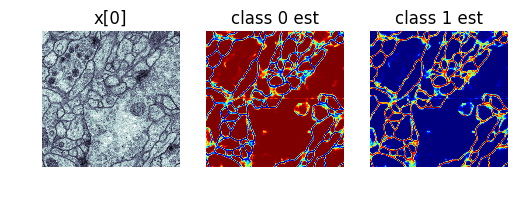

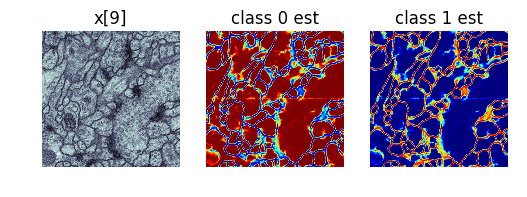

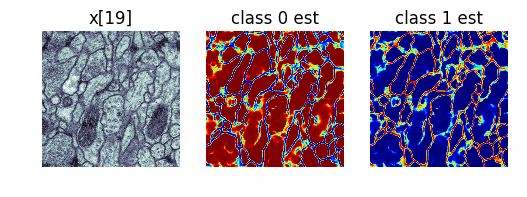

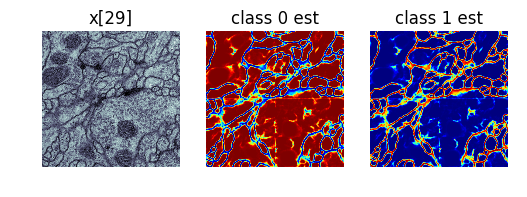

1.0
4.27303e-07


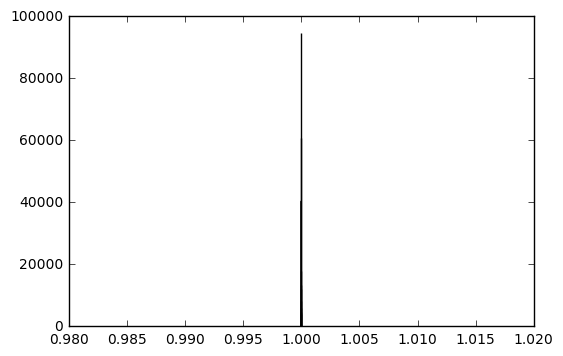

In [10]:
# visualize

for z in [0, 9, 19, 29]:
    plt.subplot(1,3,1)
    plt.imshow(X_test[z,0,...], cmap='bone'); plt.axis('off')
    plt.title('x[%d]' % z)
    plt.subplot(1,3,2)
    plt.imshow(Y_hat[z,0,...], cmap='jet'); plt.axis('off')
    plt.title('class 0 est')
    plt.subplot(1,3,3)
    plt.imshow(Y_hat[z,1,...], cmap='jet'); plt.axis('off')
    plt.title('class 1 est')
    plt.show()
    
# make sure the classification layers are as expected
net0 = Y_hat[0,0,...] + Y_hat[0,1,...]

plt.figure()
plt.hist(net0.flatten())
plt.xlim((.98, 1.02))

print(np.mean(net0))
print(np.std(net0))
